<a href="https://colab.research.google.com/github/Sohamrk24/Phase-retrieval-and-the-problem-of-Quantum-Well-using-classical-and-ML-algorithms/blob/main/Phase_estimation_GSalgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

def gerchberg_saxton(measured_amplitude,
                     num_iters=100,
                     support_mask=None,
                     initial_phase=None):
    """
    Gerchberg–Saxton phase retrieval algorithm.

    Parameters
    ----------
    measured_amplitude : 2D array
        Square root of measured intensity (|F{object}|).
    num_iters : int
        Number of GS iterations.
    support_mask : 2D boolean array, optional
        True where object is known to exist (enforce support constraint).
    initial_phase : 2D array, optional
        Initial guess for phase at detector plane. If None, random phase is used.

    Returns
    -------
    estimated_object : 2D complex array
        Retrieved complex field in the object plane.
    """
    # Initialize field in detector (Fourier) plane
    if initial_phase is None:
        phase = np.exp(1j * 2 * np.pi * np.random.rand(*measured_amplitude.shape))
    else:
        phase = np.exp(1j * initial_phase)
    field_d = measured_amplitude * phase

    # Iterative loop
    for _ in range(num_iters):
        # Back-propagate to object plane
        obj_est = np.fft.ifft2(field_d)

        # Apply object-domain constraints (support)
        if support_mask is not None:
            obj_est = obj_est * support_mask

        # Forward propagate to detector plane
        field_d = np.fft.fft2(obj_est)

        # Enforce measured amplitude and keep phase
        phase = np.exp(1j * np.angle(field_d))
        field_d = measured_amplitude * phase

    # Final object estimate
    estimated_object = np.fft.ifft2(field_d)
    return estimated_object

# Example usage
if __name__ == "__main__":
    # Create a test object (amplitude + random phase)
    N = 128
    amplitude = np.zeros((N, N))
    amplitude[N//4:3*N//4, N//4:3*N//4] = 1.0
    true_phase = np.random.rand(N, N) * 2 * np.pi
    true_object = amplitude * np.exp(1j * true_phase)

    # Simulate measurement: Fourier magnitude
    measured_field = np.fft.fft2(true_object)
    measured_amplitude = np.abs(measured_field)

    # Optional: define support mask (where amplitude > 0)
    support = amplitude > 0

    # Run GS
    recovered = gerchberg_saxton(measured_amplitude, num_iters=200, support_mask=support)

    # Compare amplitude
    recovered_amplitude = np.abs(recovered)
    print("Reconstruction complete.")
    print("True amplitude sum:", amplitude.sum())
    print("Recovered amplitude sum:", recovered_amplitude.sum())




Reconstruction complete.
True amplitude sum: 4096.0
Recovered amplitude sum: 4388.92216845302


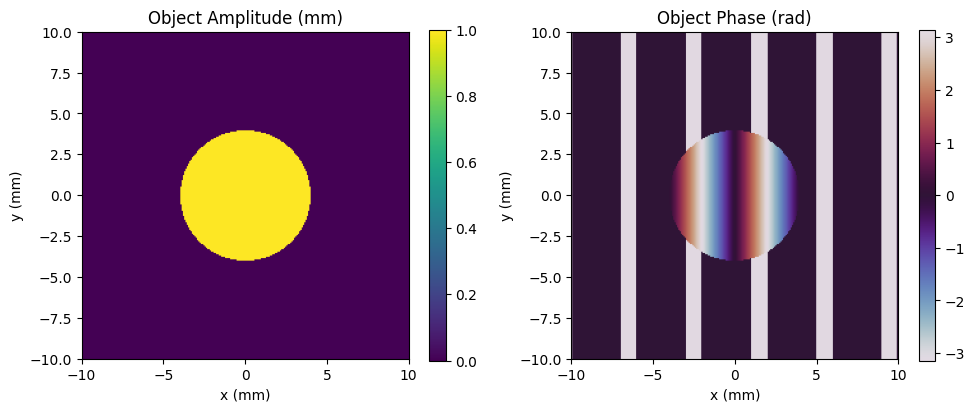

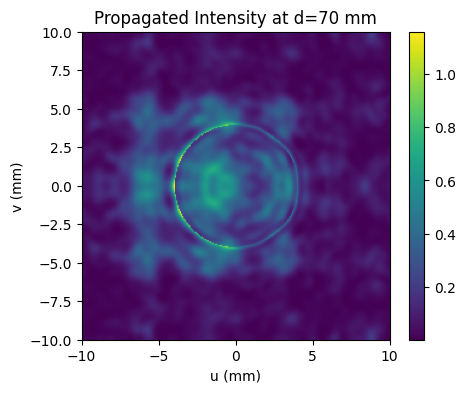

In [ ]:
## Forward _ model


import numpy as np
import matplotlib.pyplot as plt

# Parameters

##
wavelength = 1e-3  # 1 mm (300 GHz ~ 1 mm)
k = 2 * np.pi / wavelength
d = 0.07  # propagation distance (70 mm)

# Grid setup
N = 256
L = 0.02  # physical size 20 mm
dx = L / N
x = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, x)

# Define object field E0: circular aperture with a phase ramp
radius = 0.004  # 4 mm radius
aperture = (X**2 + Y**2) <= radius**2
phase_ramp = np.exp(1j * (2 * np.pi * X / radius))
E0 = aperture * phase_ramp

# Angular spectrum propagation
# Fourier coordinates
df = 1 / L
f = np.linspace(-N/2, N/2 - 1, N) * df
FX, FY = np.meshgrid(f, f)
H = np.exp(1j * 2 * np.pi * d * np.sqrt(np.maximum(0, 1/wavelength**2 - (FX**2 + FY**2))))

# Forward and inverse FFT with shift
E0_spec = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E0)))
E_d_spec = E0_spec * H
E_d = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(E_d_spec)))

# Compute intensity
I = np.abs(E_d)**2

# Plot object amplitude and phase
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(E0), extent=[-L/2*1e3, L/2*1e3, -L/2*1e3, L/2*1e3])
plt.title('Object Amplitude (mm)')
plt.xlabel('x (mm)'), plt.ylabel('y (mm)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.angle(E0), extent=[-L/2*1e3, L/2*1e3, -L/2*1e3, L/2*1e3], cmap='twilight')
plt.title('Object Phase (rad)')
plt.xlabel('x (mm)'), plt.ylabel('y (mm)')
plt.colorbar()
plt.tight_layout()
plt.show()

# Plot propagated intensity
plt.figure(figsize=(5, 4))
plt.imshow(I, extent=[-L/2*1e3, L/2*1e3, -L/2*1e3, L/2*1e3])
plt.title('Propagated Intensity at d=70 mm')
plt.xlabel('u (mm)'), plt.ylabel('v (mm)')
plt.colorbar()
plt.show()


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.4188 - val_loss: 0.3645
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.4066 - val_loss: 0.3627
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.4541 - val_loss: 0.3615
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.4212 - val_loss: 0.3617
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.3938 - val_loss: 0.3592


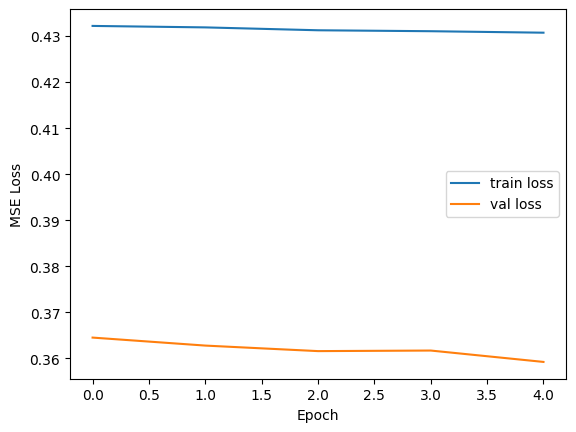

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


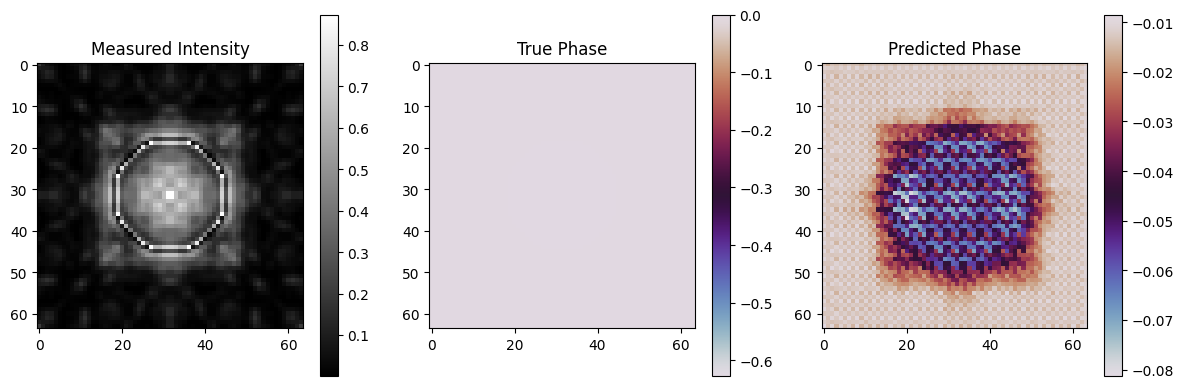

In [ ]:
## NN Testing

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Parameters
wavelength = 1e-3  # 1 mm
d = 0.07  # 70 mm
N = 64  # image size for training
L = 0.02  # 20 mm extent
dx = L / N

# Frequency grids for propagation
df = 1 / L
f = np.linspace(-N/2, N/2 - 1, N) * df
FX, FY = np.meshgrid(f, f)
H = np.exp(1j * 2 * np.pi * d * np.sqrt(np.maximum(0, 1/wavelength**2 - (FX**2 + FY**2))))

def simulate_sample():
    """Generate one sample: random phase object and its intensity measurement."""
    # Random circular aperture with random phase
    radius = np.random.uniform(0.003, 0.005)
    x = np.linspace(-L/2, L/2, N)
    X, Y = np.meshgrid(x, x)
    aperture = (X**2 + Y**2) <= radius**2
    phase = np.exp(1j * np.random.uniform(-np.pi, np.pi) * aperture)
    E0 = aperture * phase

    # Angular spectrum propagation
    E0_spec = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E0)))
    E_d_spec = E0_spec * H
    E_d = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(E_d_spec)))

    intensity = np.abs(E_d)**2
    true_phase = np.angle(E0)

    return intensity.astype(np.float32), true_phase.astype(np.float32)

# Build dataset
num_samples = 200
intensities = []
phases = []
for _ in range(num_samples):
    I, ph = simulate_sample()
    intensities.append(I[..., np.newaxis])
    phases.append(ph[..., np.newaxis])
intensities = np.stack(intensities)
phases = np.stack(phases)

# Split
split = int(num_samples * 0.8)
x_train, x_test = intensities[:split], intensities[split:]
y_train, y_test = phases[:split], phases[split:]

# Define a simple CNN model
model = models.Sequential([
    layers.Input(shape=(N, N, 1)),
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2D(1, 3, activation=None, padding='same')
])

model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(x_train, y_train, epochs=5, batch_size=8, validation_split=0.1)

# Plot training loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Test on one sample
idx = 0
pred_phase = model.predict(x_test[idx:idx+1])[0, :, :, 0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Measured Intensity")
plt.imshow(x_test[idx,:,:,0], cmap='gray')
plt.colorbar()
plt.subplot(1,3,2)
plt.title("True Phase")
plt.imshow(y_test[idx,:,:,0], cmap='twilight')
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Predicted Phase")
plt.imshow(pred_phase, cmap='twilight')
plt.colorbar()
plt.tight_layout()
plt.show()
